In [1]:
import cv2
import torch
import numpy as np
from torchvision.transforms import functional as F
import os
from xml.etree import ElementTree as et

In [2]:
def run_inference(model, image_path, device, classes, confidence_threshold=0.5):
    """
    Run inference on a single image and return the predictions.

    Args:
        model (torch.nn.Module): The trained object detection model.
        image_path (str): Path to the input image.
        device (torch.device): Device to run the inference on ('cpu' or 'cuda').
        classes (list): List of class names.
        confidence_threshold (float): Minimum confidence for predictions to be considered.

    Returns:
        dict: A dictionary containing the boxes, labels, and scores of the predictions.
    """
    model.eval()

    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image_resized = cv2.resize(image_rgb, (224, 224))  # Resize to match model's input size
    image_normalized = image_resized / 255.0  # Normalize pixel values
    image_tensor = F.to_tensor(image_normalized).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(image_tensor)[0]

    # Extract predictions above the confidence threshold
    boxes = predictions['boxes'].cpu().numpy()
    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()

    filtered_boxes = []
    filtered_labels = []
    filtered_scores = []

    for box, label, score in zip(boxes, labels, scores):
        if score >= confidence_threshold:
            filtered_boxes.append(box)
            filtered_labels.append(classes[label])
            filtered_scores.append(score)

    return {
        'boxes': filtered_boxes,
        'labels': filtered_labels,
        'scores': filtered_scores
    }

In [3]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_object_detection_model(num_classes):
    """
    Create a Faster R-CNN model with a ResNet-50 backbone for object detection.

    Args:
        num_classes (int): The number of classes (including background) in the dataset.

    Returns:
        torch.nn.Module: A Faster R-CNN model with a custom classification head.
    """
    # Load a pre-trained Faster R-CNN model with a ResNet-50 backbone
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the classifier head with a new one for our dataset
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [4]:
def get_classes(path):
    classes = set()
    for filename in os.listdir(path):
        if filename.endswith('.xml'):
            with open(os.path.join(path, filename)) as f:
                tree = et.parse(f)
                root = tree.getroot()
                for obj in root.findall('object'):
                    name = obj.find('name').text
                    classes.add(name)
    return list(classes)


train_dir = 'data/karp/train'
test_dir = 'data/karp/test'

train_classes = get_classes(train_dir)
test_classes = get_classes(test_dir)
classes = list(set(train_classes + test_classes))

In [5]:
model = get_object_detection_model(len(classes))
model.load_state_dict(torch.load('logs/pytorch_model-e3.pt', weights_only=False))

<All keys matched successfully>

In [8]:
device = torch.device('cpu')

In [9]:
image_path = "data/karp/test/2-х летка нов кросс 6 (13).jpg"
predictions = run_inference(model, image_path, device, classes, confidence_threshold=0.5)

print("Predictions:")
for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
    print(f"Label: {label}, Score: {score:.2f}, Box: {box}")

Predictions:
Label: mielocit, Score: 0.97, Box: [ 55.77665   96.094734  79.74044  122.163956]
Label: mielocit, Score: 0.97, Box: [ 43.633507 115.19884   67.10116  143.57387 ]
Label: mielocit, Score: 0.96, Box: [156.14027   46.841496 176.28178   82.21068 ]
Label: mielocit, Score: 0.96, Box: [162.02051   13.327017 188.8316    36.313244]
Label: mielocit, Score: 0.96, Box: [189.12704  84.49645 212.17143 112.65686]
Label: mielocit, Score: 0.95, Box: [18.076368 48.347553 45.03226  78.87695 ]
Label: mielocit, Score: 0.95, Box: [ 91.819595 153.36249  114.93554  181.3433  ]
Label: mielocit, Score: 0.95, Box: [106.904816 177.11119  127.56798  210.36649 ]
Label: mielocit, Score: 0.94, Box: [21.992805   7.2277703 43.2486    38.418552 ]
Label: mielocit, Score: 0.94, Box: [141.08835 107.82197 164.83638 135.3692 ]
Label: mielocit, Score: 0.93, Box: [ 5.342223 28.919056 30.27947  57.7183  ]
Label: mielocit, Score: 0.93, Box: [45.41498  14.627663 66.46756  49.066628]
Label: mielocit, Score: 0.93, Box: 

In [10]:
import matplotlib.pyplot as plt

def visualize_predictions(image_path, predictions):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        text = f"{label}: {score:.2f}"
        cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

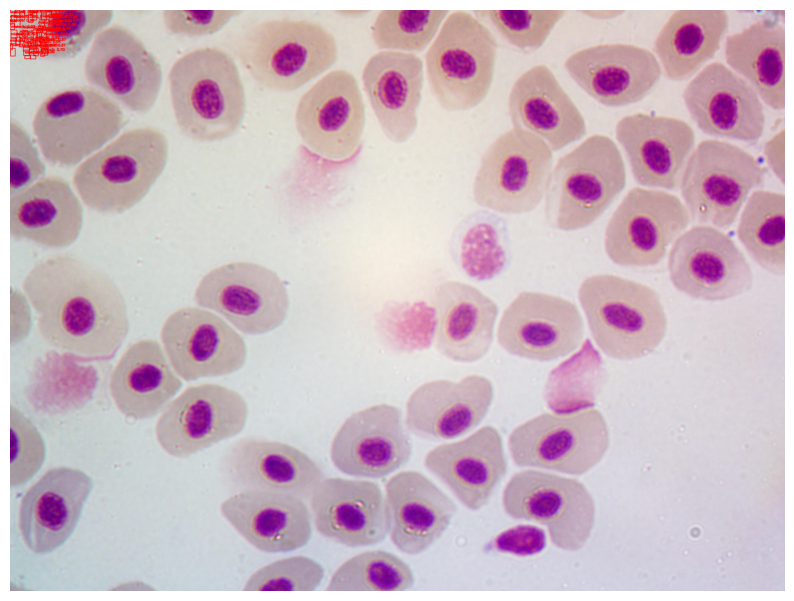

In [11]:
visualize_predictions('data/karp/test/2-х летка нов кросс 6 (13).jpg', predictions)

In [12]:
im = cv2.imread('data/karp/test/2-х летка нов кросс 6 (13).jpg')

In [13]:
im.shape

(2616, 3488, 3)

In [34]:
def rescale_predictions(predictions, original_width, original_height):
    """
    Rescale bounding box coordinates from 224x224 to the original image dimensions.

    Args:
        predictions (dict): Dictionary containing 'boxes', 'labels', and 'scores'.
        original_width (int): Original image width.
        original_height (int): Original image height.

    Returns:
        dict: Predictions with rescaled bounding box coordinates.
    """
    rescaled_boxes = []
    
    for box in predictions['boxes']:
        xmin, ymin, xmax, ymax = box
        # Rescale each coordinate
        xmin_rescaled = xmin * original_width / 224
        ymin_rescaled = ymin * original_height / 224
        xmax_rescaled = xmax * original_width / 224
        ymax_rescaled = ymax * original_height / 224
        rescaled_boxes.append([xmin_rescaled, ymin_rescaled, xmax_rescaled, ymax_rescaled])

    # Create a new predictions dictionary with rescaled boxes
    rescaled_predictions = {
        'boxes': rescaled_boxes,
        'labels': predictions['labels'],
        'scores': predictions['scores']
    }
    
    return rescaled_predictions

In [40]:
resized_width = 224
resized_height = 224  
original_width = im.shape[1]
original_height = im.shape[0]

rescaled_preds = rescale_predictions(predictions, original_width, original_height)

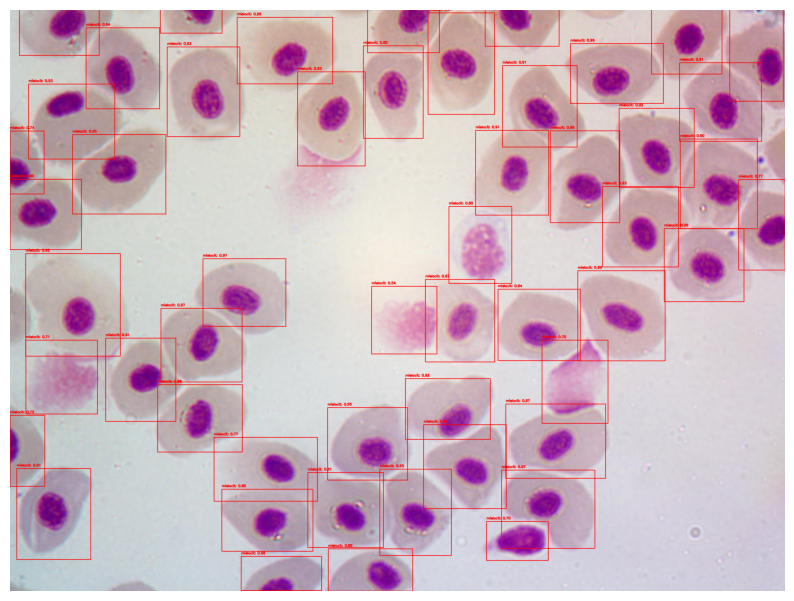

In [42]:
visualize_predictions('data/karp/test/2-х летка нов кросс 6 (13).jpg', rescaled_preds)